In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

# classificador referencial
from sklearn.dummy import DummyClassifier

# estudo linear
from sklearn.linear_model import LogisticRegression

# estudo árvore
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

# estudo SVM
# from sklearn.svm import SVR

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados
)

sns.set_theme()

In [2]:
# carregando a base de dados
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


In [3]:
# separando as colunas para os pré-processamentos
coluna_min_max = ["Time"] # o tempo vai ter apenas um ajuste de escala para acompanhar as demais features

coluna_power_transformer = ["Amount"] # essa variável teve uma grande distorção após a remoção de outliers

coluna_target = ["Class"] # coluna target

# pegando as colunas exceto diferentes das de cima
colunas_robust_scaler = [ 
    # pegando cada coluna do df que for diferente das informadas
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + coluna_target
    )
]

print(colunas_robust_scaler)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28']


- Para identificar o tipo de pré-processamento adequado para cada feature é ideal abrir o `01-jb_eda` e visuaizar os boxplots, sem esquecer que cada pré-processamento será realizado na coluna ou colunas por inteiro e não separada por classe. Com isso, devemos entender que a distribuição utilizada será da feature por inteiro.

In [4]:
# separando o X e y
X = df.drop(columns=coluna_target)
y = df[coluna_target].values.ravel() # deixando o y unidimensional, ao invés de bidimensional como dataframe

In [5]:
# criando uma variável para mostrar a diferença no uso dos métodos de unidimensionalização
y_2d = df[coluna_target] # originalmente é como dataframe
y_2d.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [6]:
# usando apenas os valores, sem os índices
y

array([0, 0, 0, ..., 1, 1, 1], shape=(256580,))

- Esse é o formato adequado de y para o treinamento de modelos.

In [7]:
# pré-processamento
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transformer", PowerTransformer(), coluna_power_transformer),
    ]
)

In [8]:
# criando a validação cruzada com estratificação
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
# criando um valor de escala dos pesos desbalanceados para os modelos xgb e lgbm
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

scale_pos_weight

np.float64(520.5040650406504)

In [10]:
# classificadores
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },

    
    # modelo linear
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"), # alguns modelos têm parâmetros para lidar com desbalanceamento
    },

    
    # modelo de árvore
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,scale_pos_weight=scale_pos_weight, n_jobs=-1
        ),
    },
    
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            scale_pos_weight=scale_pos_weight, # aplicando o valor calculado
            n_jobs=-1, 
            verbose=-1
        ),
    },

    
    # modelo kNN
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
    
}

In [11]:
# treinando os modelos e criando um dicionário com as métricas resultantes
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

# transformando o dicionário em dataframe
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.106114,0.039434,0.996239,0.499073,0.0,0.0,0.0,0.499024,0.00191,0.145548
1,DummyClassifier,0.117092,0.037876,0.996103,0.499004,0.0,0.0,0.0,0.499102,0.00191,0.154968
2,DummyClassifier,0.140101,0.053988,0.996044,0.498975,0.0,0.0,0.0,0.499082,0.00191,0.194089
3,DummyClassifier,0.114005,0.032257,0.9962,0.504104,0.010152,0.010204,0.010101,0.498916,0.001929,0.146263
4,DummyClassifier,0.056137,0.022277,0.996103,0.514136,0.029126,0.028037,0.030303,0.499102,0.001929,0.078413
5,LogisticRegression,2.619167,0.15292,0.98328,0.935609,0.168605,0.093148,0.887755,0.985234,0.608503,2.772088
6,LogisticRegression,2.816277,0.165706,0.977785,0.958317,0.138973,0.075041,0.938776,0.987455,0.731336,2.981983
7,LogisticRegression,2.242523,0.121223,0.978545,0.958698,0.143191,0.077506,0.938776,0.978128,0.800227,2.363746
8,LogisticRegression,2.468098,0.276608,0.981292,0.940221,0.156415,0.085659,0.89899,0.97971,0.687418,2.744707
9,LogisticRegression,3.163272,0.276428,0.978252,0.95382,0.141538,0.076603,0.929293,0.981516,0.738762,3.4397


In [12]:
# agrupando o a média do resultado das métricas pelo modelo, ordenando os modelos pela métrica de foco
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.10669,0.037167,0.996138,0.503058,0.007856,0.007648,0.008081,0.499045,0.001918,0.143856
LGBMClassifier,21.246692,0.115449,0.938261,0.910207,0.074547,0.039382,0.882045,0.905443,0.035513,21.362141
DecisionTreeClassifier,13.306941,0.071434,0.999135,0.873814,0.768226,0.790402,0.748011,0.873814,0.591497,13.378375
LogisticRegression,2.661868,0.198577,0.979831,0.949333,0.149744,0.081591,0.918718,0.982408,0.713249,2.860445
KNeighborsClassifier,0.479233,19.264817,0.999462,0.882054,0.844453,0.945503,0.764193,0.928754,0.818819,19.74405
XGBClassifier,14.262145,0.208305,0.999622,0.923736,0.895317,0.949773,0.847557,0.986293,0.889975,14.47045


- Como o foco principal é identificar todas as fraudes em transações, poderíamos utilizar a métrica recall, mas não podemos ter muitas transações legítimas erroneamente classificadas como fraude, que poderia ser inconveniente para o cliente. Com isso, usaremos uma métrica que busca um balanceamento entre taxa de acertos dentre as tentativas e taxa de acertos entre os que realmente são certos, um balanceamento entre recall e precision é a métrica average_precision, que mede a área sob a curva da precision-recall (AUPRC). Usar a métrica average_precision é eficiente para bases de dados severamente desbalanceadas, na busca por menos erros.

- O desempenho da média das métricas dos modelos:
    - Alguns modelos estão com uma precisão alta e recall baixo, outros modelos estão com uma precisão baixa e um recall alto, em consequência, o F1-score e average_precision são afetados positivamente ou negativamente.
    - O modelo que se destacou com um balanceamento entre todas as métricas em nível alto foi o `XGBClassifier`, se destacando com o melhor desempenho.

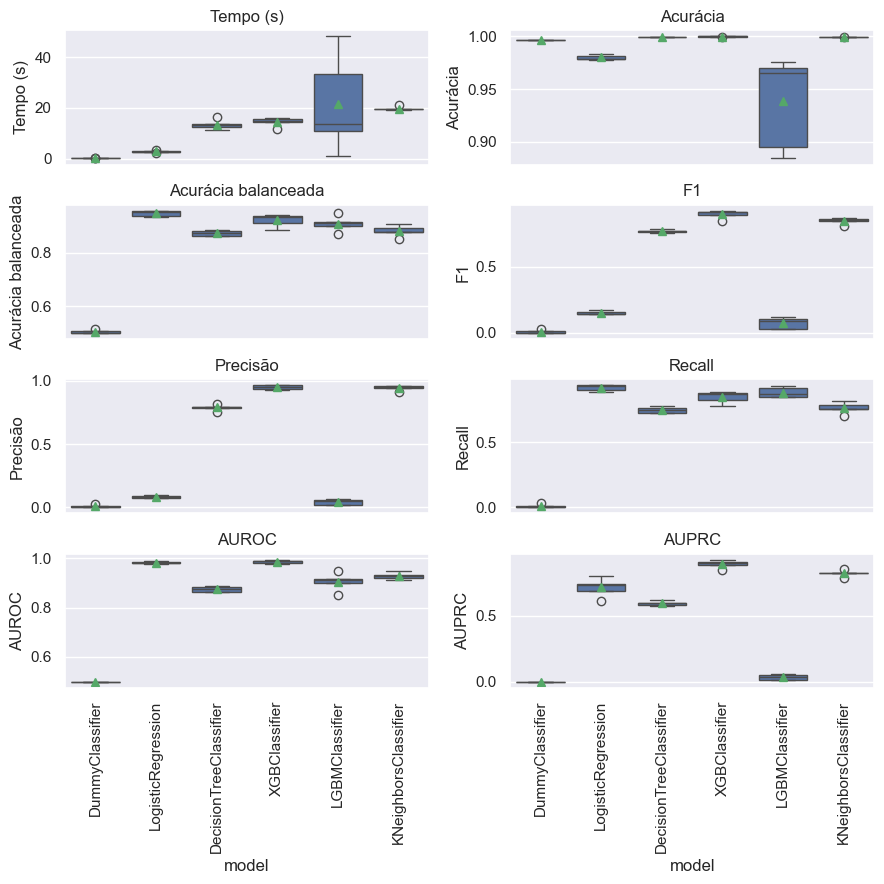

In [13]:
# visualizando graficamente a comparação entre os modelo
plot_comparar_metricas_modelos(df_resultados)

- Além do tempo de treinamento ser rápido, as métricas do modelo XGBClassifier estão superiores pela constância

Será que é possível remover mais features para tornar a pesquisa de grade menos demorada e ganhar tempo com a otimização?

In [14]:
# como os classificadores estão em um dicionário, vamos pegar o XGBClassifier
classificadores["XGBClassifier"]

{'preprocessor': None,
 'classificador': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, ...)}

In [15]:
# treinando apenas o XGBClassifier para usar o resultados das métricas como referência
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.57683921, 0.65573788, 0.61459565, 0.59087491, 0.62377477]),
 'score_time': array([0.05941939, 0.0579803 , 0.05748081, 0.05700135, 0.05673599]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

- Será que removendo algumas features o resultado da Área sob a curva Precision-Recall (AUPRC) manteria os mesmos resultados ou teria uma perda mínima? Se isso acontecer, teríamos um ganho no momento de fazer a pesquisa de grade, diminuindo a dimensionalidade das features pela remoção das features com menor importância para a predição do target.

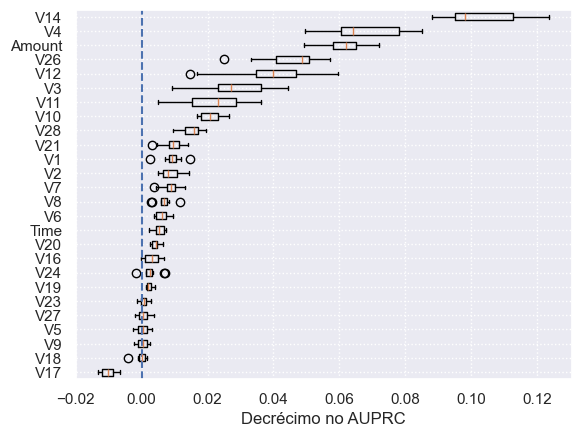

In [16]:
# separando os dados de treino e teste, usando um parâmetro de estratificação devido ao desbalanceamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

# pegando o classificador do dicionário de classificadores
clf = classificadores["XGBClassifier"]["classificador"]

# fazendo o treinamento do classificador
clf.fit(X_train, y_train)

# separando a permutação das features
perm_imp = permutation_importance(
    clf, # classificador
    X_test, # X
    y_test, # y
    n_repeats=10, # repetindo a permutação n vezes
    random_state=RANDOM_STATE, # fixando pseudoaleatoriedade
    n_jobs=-1, # usando todos os núcleos do processador
    scoring="average_precision", # métrica de refit
)

# criando um gráfico para exibir a permutação das features de maneira decrescente
fig, ax = plt.subplots()

# ordenando os valores das médias das importâncias das features
ordem = perm_imp.importances_mean.argsort()

# criando boxplots do ordenamento dos resultados da permutação de features
ax.boxplot(
    perm_imp.importances[ordem].T, # buscando os valores da importância das features ordenadas, além de fazer transposição no conjunto de dados
    vert=False, # vertical é falso, porque o boxplot precisa ser horizontal
    tick_labels=X.columns[ordem] # rótulos ordenados
)
ax.axvline(x=0, linestyle="--") # colocando uma linha tracejada para definir o 0
ax.set_xlabel("Decrécimo no AUPRC") # rótulo no eixo x
ax.grid(linestyle=":") # estilo da grade

- Podemos adotar algum critério para remover as features que não tem tanto impacto nessa métrica, isso gastará menos tempo na otimização de hiperparâmetros do modelo.

In [17]:
# verificando os valores médios da permutação
perm_imp.importances_mean

array([ 0.00527042,  0.00928424,  0.00870414,  0.02871306,  0.06841606,
        0.00044666,  0.00616417,  0.00869138,  0.00665531,  0.00021158,
        0.0207063 ,  0.02268825,  0.03889337,  0.10351298,  0.00300705,
       -0.01019586, -0.00024938,  0.00235822,  0.00421469,  0.00933825,
        0.00068464,  0.00278895,  0.04534865,  0.0005824 ,  0.01521219,
        0.06118491])

In [18]:
# definindo um critério de features com impacto abaixo de 0.01
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V23', 'V24', 'V27'],
      dtype='object')

- Por meio desse procedimento muitas features serão removidas, sem perder tanto desempenho, que é um dos pontos importantes

In [19]:
# sobrescrevendo X, removendo as features com importância inferior a 1% na métrica AUPRC
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V26', 'V28', 'Amount'], dtype='object')

- Apenas as variáveis acima foram mantidas, elas têm um impacto maior ou igual a 1% em sua permutação

In [20]:
# retreinando o modelo com a nova redução de feature
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.32483268, 0.26546311, 0.27044415, 0.2527256 , 0.2553246 ]),
 'score_time': array([0.05358648, 0.05532765, 0.05152106, 0.05130744, 0.05707312]),
 'test_accuracy': array([0.99941539, 0.99962975, 0.99951282, 0.99953231, 0.99949334]),
 'test_balanced_accuracy': array([0.88258473, 0.93870717, 0.91827949, 0.91911382, 0.92413504]),
 'test_f1': array([0.83333333, 0.90052356, 0.86772487, 0.87368421, 0.86597938]),
 'test_precision': array([0.91463415, 0.92473118, 0.9010989 , 0.91208791, 0.88421053]),
 'test_recall': array([0.76530612, 0.87755102, 0.83673469, 0.83838384, 0.84848485]),
 'test_roc_auc': array([0.97385246, 0.97489323, 0.98426693, 0.97711579, 0.9926295 ]),
 'test_average_precision': array([0.82628555, 0.88727911, 0.88560336, 0.87943563, 0.88295909])}

- Comparando as métricas de referência com as métricas após a remoção das features, boa parte dos valores tiveram uma leve queda, mas os resultados continuam aceitáveis e altos, indicando que a remoção das features não teve um impacto tão grande.

In [21]:
# grade de parâmetros
param_grid = {
    "clf__max_depth": [6, 10], # profundidade da árvore
    "clf__subsample": [0.6, 0.8, 1.0], # proporção mínima de amostras para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0], # proporção mínima de features para cada árvore
    "clf__learning_rate": [0.1, 0.3, 0.4], # taxa de aprendizado
    "clf__n_estimators": [100, 200], # número de árvores
    "clf__reg_lambda": [1, 2, 5], # regularização L2
    "clf__reg_alpha": [0, 0.5, 1], # regularização L1
}

In [22]:
# definindo m classificador com alguns parâmetros fixos
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight)

# busca em grade da melhor combinação de hiperparâmetros
grid_search = grid_search_cv_classificador(
    classificador=clf, # classificador
    param_grid=param_grid, # grade de parâmetros
    cv=kf, # validação cruzada com estratificação
    preprocessor=None, # sem pré-processamento
    refit_metric="average_precision" # métrica de refit
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__learning_rate': [0.1, 0.3, 0.4],
                         'clf__max_depth': [6, 10],
                         'clf__n_estimators': [100, 200],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [23]:
# treinando o modelo com a otimização de hiperparâmetros
grid_search.fit(X, y)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__learning_rate': [0.1, 0.3, 0.4],
                         'clf__max_depth': [6, 10],
                         'clf__n_estimators': [100, 200],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [24]:
# melhores parâmetros do classificador
grid_search.best_params_

{'clf__colsample_bytree': 0.8,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 10,
 'clf__n_estimators': 200,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 2,
 'clf__subsample': 1.0}

In [25]:
# verificando a métrica de refit
grid_search.best_score_

np.float64(0.8811285355087008)

- Após remover as 21 features com menor importância do dataframe original, conseguimos manter a métrica average_precision em ~0.88, isso significa que mesmo removendo a maioria das features o modelo conseguiu performar bem, com perda mínima de desempenho.

In [26]:
# verificando os parâmetros do melhor estimador
grid_search.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [27]:
# verificando as outras métricas de classificação armazenadas na função de grid_search

# verificando cada métrica do resultado que comece com "test"
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]

# colocando o prefixo "mean_" nas colunas_test
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]

colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [28]:
# iterando nas colunas_test_mean para exibir a métrica e seu valor
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.9995440018707615
mean_test_balanced_accuracy: 0.9165880237051981
mean_test_f1: 0.8746967908389435
mean_test_precision: 0.9215609477209229
mean_test_recall: 0.8333127190270048
mean_test_roc_auc: 0.9852851940640953
mean_test_average_precision: 0.8811285355087008


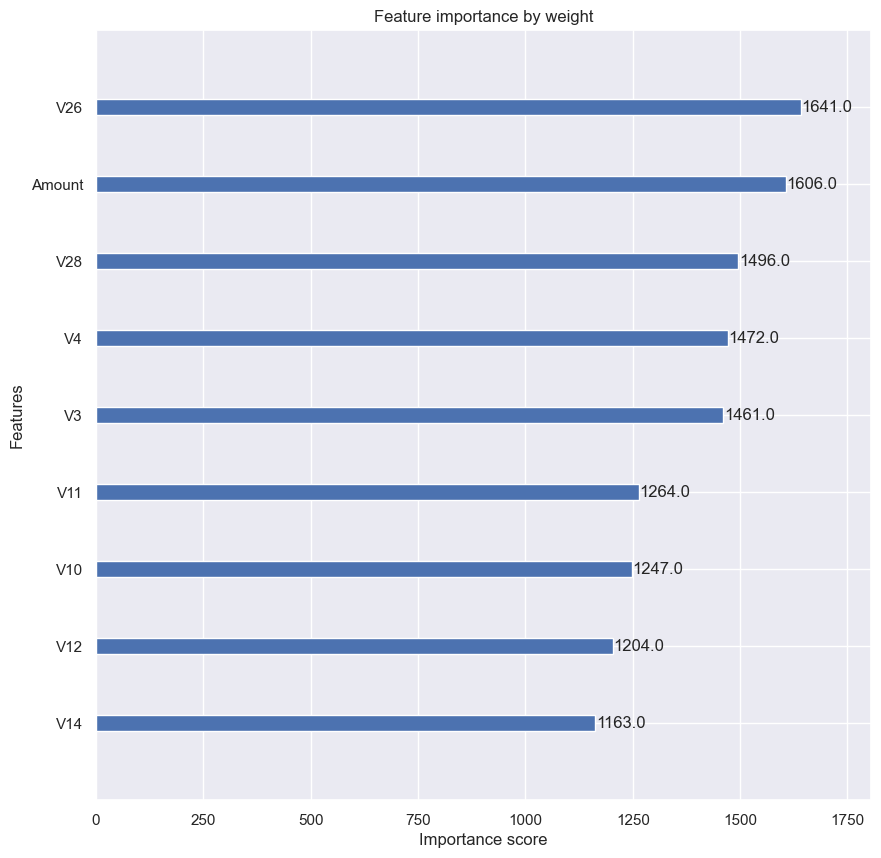

In [29]:
# verificando a importância das features
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight", # com base na importância de peso
    title="Feature importance by weight"
)

plt.show()

- A importância por peso indica quantas vezes uma variável é usada nas divisões das árvores, refletindo frequência de uso pelo modelo.

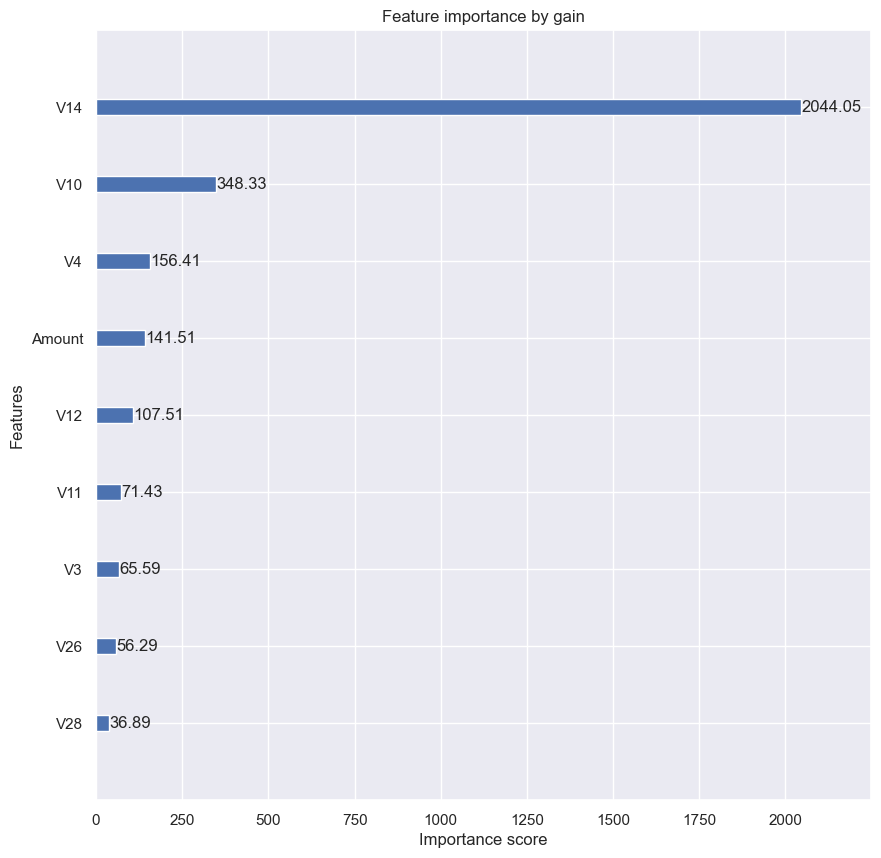

In [30]:
# verificando a importância das features
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain", # com base na importância de ganho
    title="Feature importance by gain",
    values_format="{v:.2f}" # formatando para duas casas decimais
)

plt.show()

- A importância por ganho mede o quanto cada variável contribui, em média, para reduzir o erro do modelo, refletindo impacto real na performance. A métrica por ganho é a mais adequada para avaliar a relevância efetiva das variáveis.

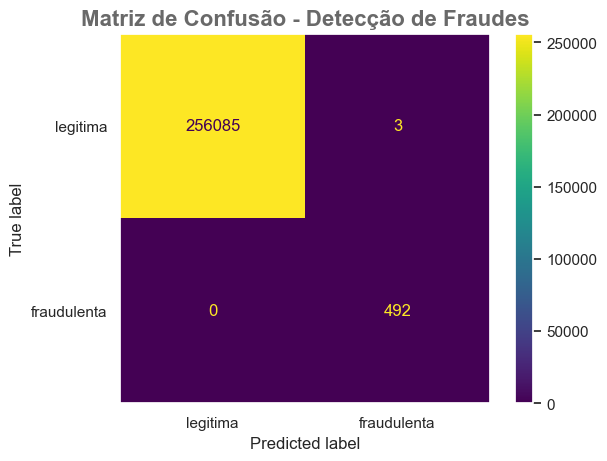

In [31]:
# criando uma matriz de confusão com a quantidade de acertos
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, # melhor estimador
    X, 
    y,
    display_labels=["legitima", "fraudulenta"], # nome das classes no target
)

plt.title("Matriz de Confusão - Detecção de Fraudes", fontsize=16, weight="bold", color="dimgrey")

plt.grid(False) # removendo a grade do gráfico

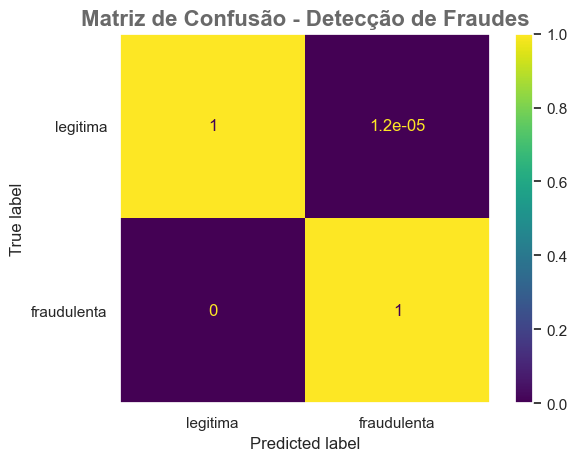

In [32]:
# criando uma matriz de confusão com o percentual de acertos por linha
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, # melhor estimador
    X, 
    y,
    display_labels=["legitima", "fraudulenta"], # nome das classes no target
    normalize="true"
)

plt.title("Matriz de Confusão - Detecção de Fraudes", fontsize=16, weight="bold", color="dimgrey")

plt.grid(False) # removendo a grade do gráfico

- O modelo XGBClassifier identificou corretamente 100% das 492 fraudes em transações, além de errar apenas 3 transações dentre as 256.088 classificadas como legítimas, com uma proporção significativamente pequena, representando 0,000012% de identificações incorretas.